**RNN**
---
* Sıralı veriler üzernde çalışan özel bir derin öğrenme modelidir
* Önceki girdileri "hatırlayarak" ve bu bilgileri kullanarak sonraki çıktıları tahmin eder
* Nlp, zaman serisi , konuşma tanıma gibi alanlarda yaygın kulllanılır

**LSTM**
---
* Derin öğrenme alanında kullanılan özel bir RNN mimarisidr
* Diğer RNN türlerin göre gradyan kaybolma problemine daha dirençlidir
* Uzun metin analizinde daha başarılıdır
* 3 kapısı vardır : forget gate input gate output gate
* NLP , konuşma tanıma,zaman serisi stok analizi,makine çevirisinde kullanılır
* RNN'lerin geliştirilmiş bir versiyonudur


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0228 - val_loss: 0.0362
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0311
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0439
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0091 - val_loss: 0.0423
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0285
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0311
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 0.0349
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0085 - val_loss: 0.0318
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - val_loss: 0.0361
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0238
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss:

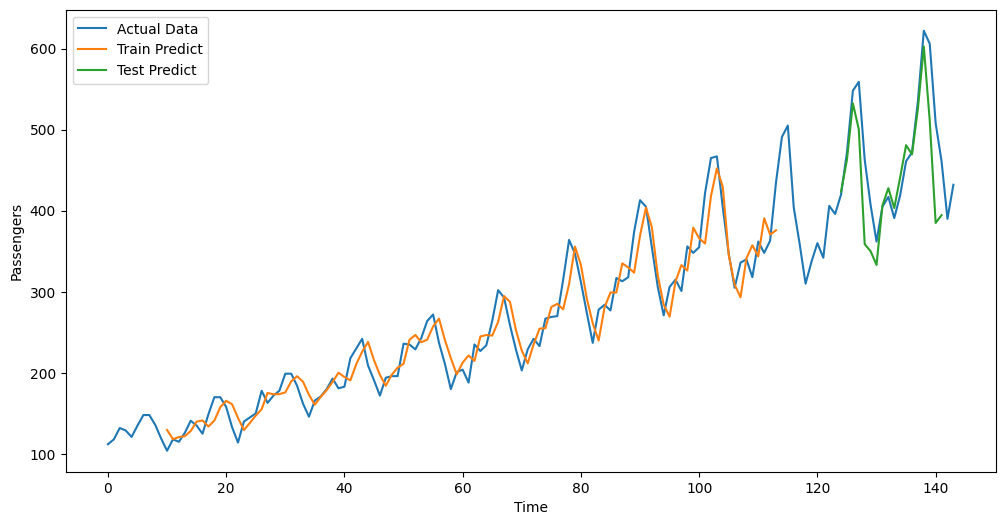

Train MAE: 19.21
Test MAE: 37.20
Train MSE: 559.78
Test MSE: 2268.51
Train RMSE: 23.66
Test RMSE: 47.63


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pickle

# Veriyi yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

# Veriyi 0 ile 1 arasında ölçekleyelim
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma (80% eğitim, 20% test)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
#(RNN olduğu için) sıralı seriler şeklinde koparmak için bu şekilde veriyi ayırdık


# LSTM modeli için veri şekillendirme
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Veriyi LSTM girişine uygun hale getirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

# Tahminler
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri ölçeklendirmeyi geri alma
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Gerçek değerleri ölçeklendirmeyi geri alma
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Eğitim ve test verisi için tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(range(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Modeli kaydetme
model.save('air_passenger_lstm_model.h5')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE, MSE ve RMSE hesaplama
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
